#### By: Peyman Shahidi
#### Created: Oct 19, 2025
#### Last Edit: Oct 27, 2025

<br>

In [1]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [2]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects/execTypeVaryingDWA_anthropicIndex'
output_plot_path = f"{main_folder_path}/writeup/plots/anthropic_AI_index"

In [3]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [4]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Drop  columns to avoid double counting
# Note: In ~4k instances, the same task is mapped to multiple DWAs
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# Remove duplicate rows
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates().reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

ONET.head(5)

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Relevance,Base_SOC_Code,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,94.19,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,98.79,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,100.00,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,95.84,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,90.47,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives


In [5]:
# Load GPTs are GPTs full label dataset
gpts_full_labels = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/full_labelset.tsv', sep="\t")

# Keep relevant columns only
gpts_full_labels = gpts_full_labels[['O*NET-SOC Code', 'Task ID', 'Task', 'Task Type', 'Title', 'gpt4_exposure', 'human_labels']]

# Convert Task ID to integer
gpts_full_labels['Task ID'] = gpts_full_labels['Task ID'].astype(int)

# Remove apostrophes for consistency
gpts_full_labels = gpts_full_labels.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Rename columns
gpts_full_labels = gpts_full_labels.rename(columns={
    'Task': 'Task Title',
    'Title': 'Occupation Title'
})

# Print length of dataset
print(f"Number of rows in GPTs full labels dataset: {len(gpts_full_labels):,}")


gpts_full_labels.head(5)

Number of rows in GPTs full labels dataset: 19,265


,O*NET-SOC Code,Task ID,Task Title,Task Type,Occupation Title,gpt4_exposure,human_labels
0,11-1011.00,8823,Direct or coordinate an organizations financia...,Core,Chief Executives,E2,E0
1,11-1011.00,8831,Appoint department heads or managers and assig...,Core,Chief Executives,E0,E0
2,11-1011.00,8825,Analyze operations to evaluate performance of ...,Core,Chief Executives,E2,E2
3,11-1011.00,8826,"Direct, plan, or implement policies, objective...",Core,Chief Executives,E2,E0
4,11-1011.00,8827,"Prepare budgets for approval, including those ...",Core,Chief Executives,E2,E2


In [6]:
# Merge with ONET dataset to get hierarchical codes and titles
ONET = ONET.merge(gpts_full_labels, on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], how='left')

# Check how many tasks were not matched
unmatched_tasks = ONET[ONET['gpt4_exposure'].isna()]
print(f"Number of unmatched tasks: {len(unmatched_tasks):,}")

Number of unmatched tasks: 791


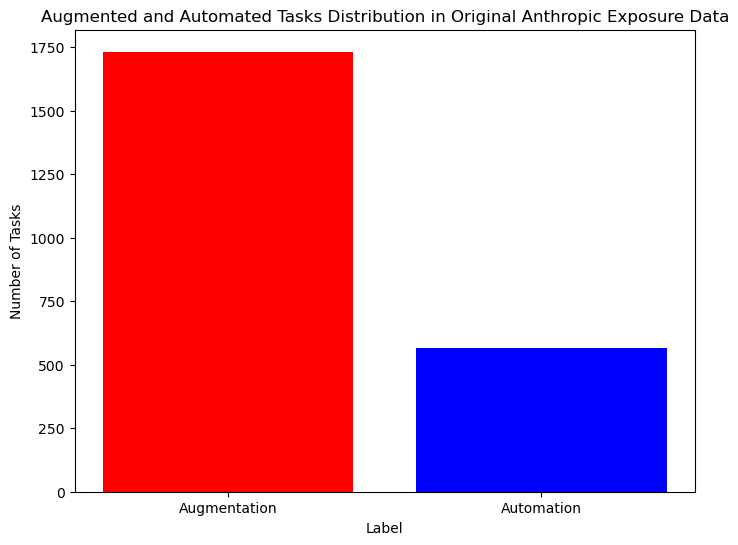

In [7]:
# Merge with Anthropic exposure data
anthropic_exposure = pd.read_csv(f'{input_data_path}/Anthropic_EconomicIndex/automation_vs_augmentation_by_task.csv')

# Remove if all entries are filtered:
anthropic_exposure = anthropic_exposure[anthropic_exposure['filtered'] != 1].reset_index(drop=True)

# Create new columns:
# Sum feedback loop and directive into Automation
# Sum validation, iteration, and learning into Augmentation
anthropic_exposure['automation'] = anthropic_exposure.apply(lambda row: row['feedback_loop'] + row['directive'], axis=1)
anthropic_exposure['augmentation'] = anthropic_exposure.apply(lambda row: row['validation'] + row['task_iteration'] + row['learning'], axis=1)

# Assign labels: take the max of automation, augmentation, manual and assign the corresponding label
def assign_label(row):
    max_value = max(row['automation'], row['augmentation'])
    if max_value == row['automation']:
        return 'Automation'
    elif max_value == row['augmentation']:
        return 'Augmentation'

anthropic_exposure['label'] = anthropic_exposure.apply(assign_label, axis=1)

# Filter to only keep the relevant columns
anthropic_exposure = anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']]

# Plot histogram of the label column to see share of each label
label_counts = anthropic_exposure['label'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color=['red', 'blue'])
plt.title('Augmented and Automated Tasks Distribution in Original Anthropic Exposure Data')
plt.xlabel('Label')
plt.ylabel('Number of Tasks')
# plt.savefig(f'{output_plot_path}/anthropicIndex_automatedAugmented_taskDist.png')
plt.show()

In [8]:
# Print number of unique tasks in ONET dataset
print(f"Number of unique tasks in ONET dataset: {ONET['Task Title'].nunique():,}")

# Print number of unique tasks in Anthropic exposure dataset
print(f"Number of unique tasks in Anthropic exposure dataset: {anthropic_exposure['task_name'].nunique():,}")


# Add normalized task title to ONET for merging
ONET["task_normalized"] = ONET["Task Title"].str.lower().str.strip()


# Merge ONET and Anthropic exposure data on the normalized task title
merged_data = pd.merge(ONET, anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']], left_on="task_normalized", right_on="task_name", how="left")

# Fill the NaN values of the label column in merged dataset as Manual
merged_data['label'] = merged_data['label'].fillna('Manual')

# Print distribution after filling NaN values
print(f"\nDistribution of labels after filling NaN values with 'Manual':")
print(merged_data['label'].value_counts())
print(f"Total tasks: {len(merged_data):,}")

merged_data.head()

Number of unique tasks in ONET dataset: 16,913
Number of unique tasks in Anthropic exposure dataset: 2,298

Distribution of labels after filling NaN values with 'Manual':
label
Manual          15605
Augmentation     1626
Automation        722
Name: count, dtype: int64
Total tasks: 17,953

Distribution of labels after filling NaN values with 'Manual':
label
Manual          15605
Augmentation     1626
Automation        722
Name: count, dtype: int64
Total tasks: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title,gpt4_exposure,human_labels,task_normalized,task_name,automation,augmentation,label
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,NaN,NaN,direct or coordinate an organization's financi...,direct or coordinate an organization's financi...,0.35,0.57,Augmentation
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E0,E0,"confer with board members, organization offici...","confer with board members, organization offici...",0.25,0.61,Augmentation
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E2,analyze operations to evaluate performance of ...,analyze operations to evaluate performance of ...,0.31,0.66,Augmentation
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E0,"direct, plan, or implement policies, objective...",NaN,NaN,NaN,Manual
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E2,"prepare budgets for approval, including those ...",NaN,NaN,NaN,Manual


In [9]:
# # Reshuffle task assignments while preserving SOC hierarchy structure
# # Each occupation unit (O*NET-SOC Code + hierarchy levels) stays intact, but tasks are randomly reassigned
# # COMPLETELY UNRESTRICTED: Each task assigned to random occupation, no constraints on tasks per occupation

# # Create a copy of the data for reshuffling
# reshuffled_data = merged_data.copy()

# # Create SOC hierarchy levels with descriptive names from the O*NET-SOC Code
# reshuffled_data['soc_Major_Group_Code_Code_Code'] = reshuffled_data['O*NET-SOC Code'].str[:2]
# reshuffled_data['soc_minor_group'] = reshuffled_data['O*NET-SOC Code'].str[:5] 
# reshuffled_data['soc_broad_occupation'] = reshuffled_data['O*NET-SOC Code'].str[:8]
# reshuffled_data['soc_detailed_occupation'] = reshuffled_data['O*NET-SOC Code']

# # Get unique occupation units (with all hierarchy levels intact)
# occupation_units = reshuffled_data[['O*NET-SOC Code', 'Occupation Title', 'soc_major_group', 
#                                    'soc_minor_group', 'soc_broad_occupation', 'soc_detailed_occupation']].drop_duplicates()

# print(f"Number of unique occupation units: {len(occupation_units):,}")

# # Get all unique tasks (each task appears only once)
# unique_tasks = reshuffled_data[['Task ID', 'Task Title', 'Task Type', 'gpt4_exposure', 
#                                'human_labels', 'task_normalized', 'task_name', 
#                                'automation', 'augmentation', 'label']].drop_duplicates()

# print(f"Number of unique tasks: {len(unique_tasks):,}")

# # Set random seed for reproducibility
# np.random.seed(42)

# # UNRESTRICTED ASSIGNMENT: Each task randomly assigned to any occupation unit
# # No constraints on how many tasks per occupation
# n_tasks = len(unique_tasks)
# n_occupations = len(occupation_units)

# # Random assignment: each task gets assigned to a completely random occupation
# random_occupation_indices = np.random.choice(n_occupations, size=n_tasks, replace=True)

# print(f"Assigning {n_tasks:,} tasks randomly across {n_occupations:,} occupation units")

# # Create the reshuffled dataset
# reshuffled_list = []

# for task_idx in range(n_tasks):
#     occ_idx = random_occupation_indices[task_idx]
    
#     # Get task information
#     task_row = unique_tasks.iloc[task_idx].to_dict()
    
#     # Get occupation information  
#     occ_row = occupation_units.iloc[occ_idx].to_dict()
    
#     # Combine them
#     combined_row = {**task_row, **occ_row}
#     reshuffled_list.append(combined_row)

# # Create the reshuffled DataFrame
# reshuffled_data = pd.DataFrame(reshuffled_list)

# print(f"Reshuffled dataset created with {len(reshuffled_data):,} rows")

# # Verify the reshuffling worked correctly
# print(f"\nOriginal dataset task distribution by occupation:")
# original_task_counts = merged_data.groupby('O*NET-SOC Code')['Task ID'].nunique()
# print(f"Min tasks per occupation: {original_task_counts.min()}")
# print(f"Max tasks per occupation: {original_task_counts.max()}")
# print(f"Mean tasks per occupation: {original_task_counts.mean():.2f}")
# print(f"Std tasks per occupation: {original_task_counts.std():.2f}")

# print(f"\nReshuffled dataset task distribution by occupation:")
# reshuffled_task_counts = reshuffled_data.groupby('O*NET-SOC Code')['Task ID'].nunique()
# print(f"Min tasks per occupation: {reshuffled_task_counts.min()}")
# print(f"Max tasks per occupation: {reshuffled_task_counts.max()}")
# print(f"Mean tasks per occupation: {reshuffled_task_counts.mean():.2f}")
# print(f"Std tasks per occupation: {reshuffled_task_counts.std():.2f}")

# # Count occupations with zero tasks
# zero_task_occupations = (reshuffled_task_counts == 0).sum()
# print(f"Occupations with zero tasks: {zero_task_occupations}")

# print(f"\nVerification:")
# print(f"Number of unique occupations preserved: {reshuffled_data['O*NET-SOC Code'].nunique() == merged_data['O*NET-SOC Code'].nunique()}")
# print(f"Number of unique tasks preserved: {reshuffled_data['Task ID'].nunique() == unique_tasks['Task ID'].nunique()}")
# print(f"Each task appears exactly once: {len(reshuffled_data) == len(unique_tasks)}")

# # Show SOC hierarchy column names
# print(f"\nSOC hierarchy columns created:")
# soc_columns = ['soc_major_group', 'soc_minor_group', 'soc_broad_occupation', 'soc_detailed_occupation']
# for col in soc_columns:
#     print(f"  {col}: {reshuffled_data[col].nunique():,} unique values")


# # Set reshuffled data as the final dataset
# merged_data = reshuffled_data.copy()

# # Show sample of reshuffled data
# print(f"\nSample of reshuffled data:")
# reshuffled_data.head()

In [10]:
# Drop the supplemental tasks
merged_data = merged_data[merged_data['Task Type'] != 'Supplemental'].reset_index(drop=True)

# Drop rows whose Occupation Title includes 'Teachers, Postsecondary'
merged_data = merged_data[~merged_data['Occupation Title'].str.contains('Teachers, Postsecondary')].reset_index(drop=True)

In [11]:
# Create occupation-level analysis for scatter plots
# Group by occupation and calculate label fractions and task counts
occupation_stats = []

for (soc_code, occ_title), group in merged_data.groupby(['O*NET-SOC Code', 'Occupation Title']):
    num_tasks = group['Task ID'].nunique()
    total_tasks = len(group)
    
    manual_fraction = (group['label'] == 'Manual').sum() / total_tasks
    augmentation_fraction = (group['label'] == 'Augmentation').sum() / total_tasks  
    automation_fraction = (group['label'] == 'Automation').sum() / total_tasks
    ai_fraction = augmentation_fraction + automation_fraction
    
    occupation_stats.append({
        'O*NET-SOC Code': soc_code,
        'Occupation Title': occ_title,
        'num_tasks': num_tasks,
        'manual_fraction': manual_fraction,
        'ai_fraction': ai_fraction,
        'augmentation_fraction': augmentation_fraction,
        'automation_fraction': automation_fraction
    })

occupation_analysis = pd.DataFrame(occupation_stats)

# save occupation analysis to CSV
occupation_analysis.to_csv(f'{output_data_path}/anthropic_occupationLevel_taskExposure_dataset.csv', index=False)

print(f"Number of occupations: {len(occupation_analysis):,}")
print(f"Range of tasks per occupation: {occupation_analysis['num_tasks'].min()} - {occupation_analysis['num_tasks'].max()}")
print(f"\nSample of occupation analysis:")
occupation_analysis.head(5)

Number of occupations: 837
Range of tasks per occupation: 1 - 38

Sample of occupation analysis:


,O*NET-SOC Code,Occupation Title,num_tasks,manual_fraction,ai_fraction,augmentation_fraction,automation_fraction
0,11-1011.00,Chief Executives,19,0.68,0.32,0.32,0.00
1,11-1011.03,Chief Sustainability Officers,18,0.72,0.28,0.28,0.00
2,11-1021.00,General and Operations Managers,9,0.89,0.11,0.11,0.00
3,11-2011.00,Advertising and Promotions Managers,13,0.85,0.15,0.15,0.00
4,11-2021.00,Marketing Managers,12,0.67,0.33,0.33,0.00


In [12]:
# Create Minor_Group_Code-level analysis
# Group by Minor_Group_Code and calculate label fractions and task counts
minor_group_stats = []

for (mg_code, mg_title), group in merged_data.groupby(['Minor_Group_Code', 'Minor_Group_Title']):
    num_tasks = group['Task ID'].nunique()
    num_occs = group['O*NET-SOC Code'].nunique()
    total_tasks = len(group)
    
    manual_fraction = (group['label'] == 'Manual').sum() / total_tasks
    augmentation_fraction = (group['label'] == 'Augmentation').sum() / total_tasks  
    automation_fraction = (group['label'] == 'Automation').sum() / total_tasks
    ai_fraction = augmentation_fraction + automation_fraction
    
    minor_group_stats.append({
        'Minor_Group_Code': mg_code,
        'Occupation Title': mg_title,
        'num_tasks': num_tasks,
        'num_occupations': num_occs,
        'manual_fraction': manual_fraction,
        'ai_fraction': ai_fraction,
        'augmentation_fraction': augmentation_fraction,
        'automation_fraction': automation_fraction
    })

minor_group_analysis = pd.DataFrame(minor_group_stats)

# save occupation analysis to CSV
minor_group_analysis.to_csv(f'{output_data_path}/anthropic_minorGroupLevel_taskExposure_dataset.csv', index=False)

print(f"Number of Minor Groups: {len(minor_group_analysis):,}")
print(f"Range of tasks per Minor Group: {minor_group_analysis['num_tasks'].min()} - {minor_group_analysis['num_tasks'].max()}")
print(f"\nSample of Minor Group analysis:")

# Sort Minor Groups by Fraction of Tasks to Occupations
minor_group_analysis['numTasks_to_numOccs_ratio'] = minor_group_analysis['num_tasks'] / minor_group_analysis['num_occupations']
minor_group_analysis = minor_group_analysis.sort_values(by='numTasks_to_numOccs_ratio', ascending=False).reset_index(drop=True)
minor_group_analysis.head(5)

Number of Minor Groups: 94
Range of tasks per Minor Group: 15 - 420

Sample of Minor Group analysis:


,Minor_Group_Code,Occupation Title,num_tasks,num_occupations,manual_fraction,ai_fraction,augmentation_fraction,automation_fraction,numTasks_to_numOccs_ratio
0,25-2000,"Preschool, Elementary, Middle, Secondary, and ...",362,11,0.72,0.28,0.08,0.20,32.91
1,45-3000,Fishing and Hunting Workers,27,1,1.00,0.00,0.00,0.00,27.00
2,45-1000,"Supervisors of Farming, Fishing, and Forestry ...",27,1,1.00,0.00,0.00,0.00,27.00
3,37-1000,Supervisors of Building and Grounds Cleaning a...,50,2,0.94,0.06,0.06,0.00,25.00
4,29-9000,Other Healthcare Practitioners and Technical O...,96,4,0.90,0.10,0.09,0.01,24.00


In [13]:
# # Regression: num_tasks on num_occupations with Major_Group_Code fixed effects
# # Create Major_Group_Code from Minor_Group_Code (first two characters)
# minor_group_analysis['Major_Group_Code'] = minor_group_analysis['Minor_Group_Code'].astype(str).str[:2]

# # Run OLS regression with fixed effects using statsmodels formula API
# import statsmodels.formula.api as smf
# model = smf.ols('num_occupations ~ num_tasks + C(Major_Group_Code)', data=minor_group_analysis).fit()

# # Print summary to output
# print(model.summary())

# # Save coefficients, standard errors and p-values to CSV
# coef_df = pd.DataFrame({
#     'coef': model.params,
#     'std_err': model.bse,
#     'p_value': model.pvalues
# }).reset_index().rename(columns={'index':'term'})
# coef_df.to_csv(f'{output_data_path}/majorGroup_numOccupation_on_numTasks_regression.csv', index=False)

# print('\nSaved coefficients to:', f"{output_data_path}/majorGroup_numOccupation_on_numTasks_regression.csv")

<br>

## Regress tasks of DWAs that have multiple execution types and see if previous/next tasks are indicators of AI-ability of task depending on location in the sequence

In [14]:
# If DWA columns were missing, bring them from original ONET file and recompute fractions
if 'DWA ID' not in merged_data.columns or 'DWA Title' not in merged_data.columns:
    print('DWA columns missing in merged_data; reading original ONET file to retrieve them')
    onet_dwa = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv', usecols=['Task ID','DWA ID','DWA Title'])
    onet_dwa = onet_dwa.drop_duplicates()
    merged_with_dwa = merged_data.merge(onet_dwa, on='Task ID', how='left')
    missing_dwa = merged_with_dwa['DWA ID'].isna().sum()
    print(f'Merged DWA columns in; rows with missing DWA after merge: {missing_dwa:,}')
    # Now group by DWA
    counts = merged_with_dwa.groupby(['DWA ID','DWA Title'])['label'].value_counts().unstack(fill_value=0).reset_index()
    for lbl in ['Manual','Automation','Augmentation']:
        if lbl not in counts.columns:
            counts[lbl] = 0
    counts['total'] = counts[['Manual','Automation','Augmentation']].sum(axis=1)
    counts['fraction_manual'] = counts['Manual'] / counts['total']
    counts['fraction_automation'] = counts['Automation'] / counts['total']
    counts['fraction_augmentation'] = counts['Augmentation'] / counts['total']
    counts[['fraction_manual','fraction_automation','fraction_augmentation']] = counts[['fraction_manual','fraction_automation','fraction_augmentation']].fillna(0)
    # Aggregate with unique counts
    agg = merged_with_dwa.groupby(['DWA ID','DWA Title']).agg(
        n_manual = ('label', lambda s: (s == 'Manual').sum()),
        n_automation = ('label', lambda s: (s == 'Automation').sum()),
        n_augmentation = ('label', lambda s: (s == 'Augmentation').sum()),
        num_tasks = ('Task ID', 'nunique'),
        num_occupations = ('O*NET-SOC Code', 'nunique')
    ).reset_index()
    agg['total'] = agg['n_manual'] + agg['n_automation'] + agg['n_augmentation']
    agg['fraction_manual'] = agg['n_manual'] / agg['total']
    agg['fraction_automation'] = agg['n_automation'] / agg['total']
    agg['fraction_augmentation'] = agg['n_augmentation'] / agg['total']
    agg[['fraction_manual','fraction_automation','fraction_augmentation']] = agg[['fraction_manual','fraction_automation','fraction_augmentation']].fillna(0)
    # Add AI fraction as sum of automation and augmentation fractions
    agg['fraction_ai'] = agg['fraction_automation'] + agg['fraction_augmentation']
    dwa_df = agg[['DWA ID','DWA Title','fraction_manual','fraction_automation','fraction_augmentation','fraction_ai','num_tasks','num_occupations']].copy()
    # Sort by fraction_ai descending
    dwa_df = dwa_df.sort_values(by=['fraction_ai', 'fraction_automation'], ascending=False).reset_index(drop=True)
    out_path = f'{output_data_path}/dwa_label_fraction_by_dwa.csv'
    dwa_df.to_csv(out_path, index=False)
    print('Saved DWA-level fractions to:', out_path)
    try:
        display(dwa_df.head())
    except Exception:
        print(dwa_df.head().to_string(index=False))
else:
    print('DWA columns already present; computing aggregates with existing columns')
    agg = merged_data.groupby(['DWA ID','DWA Title']).agg(
        n_manual = ('label', lambda s: (s == 'Manual').sum()),
        n_automation = ('label', lambda s: (s == 'Automation').sum()),
        n_augmentation = ('label', lambda s: (s == 'Augmentation').sum()),
        num_tasks = ('Task ID', 'nunique'),
        num_occupations = ('O*NET-SOC Code', 'nunique')
    ).reset_index()
    agg['total'] = agg['n_manual'] + agg['n_automation'] + agg['n_augmentation']
    agg['fraction_manual'] = agg['n_manual'] / agg['total']
    agg['fraction_automation'] = agg['n_automation'] / agg['total']
    agg['fraction_augmentation'] = agg['n_augmentation'] / agg['total']
    agg[['fraction_manual','fraction_automation','fraction_augmentation']] = agg[['fraction_manual','fraction_automation','fraction_augmentation']].fillna(0)
    # Add AI fraction as sum of automation and augmentation fractions
    agg['fraction_ai'] = agg['fraction_automation'] + agg['fraction_augmentation']
    dwa_df = agg[['DWA ID','DWA Title','fraction_manual','fraction_automation','fraction_augmentation','fraction_ai','num_tasks','num_occupations']].copy()
    # Sort by fraction_ai descending
    dwa_df = dwa_df.sort_values(by=['fraction_ai', 'fraction_automation'], ascending=False).reset_index(drop=True)
    out_path = f'{output_data_path}/dwa_label_fraction_by_dwa.csv'
    dwa_df.to_csv(out_path, index=False)
    print('Saved DWA-level fractions to:', out_path)
    try:
        display(dwa_df.head())
    except Exception:
        print(dwa_df.head().to_string(index=False))



# # Plot distribution of fraction_ai for DWAs
# import os
# csv_path = f'{output_data_path}/dwa_label_fraction_by_dwa.csv'
# if not os.path.exists(csv_path):
#     print('DWA CSV not found at', csv_path)
# else:
#     df = pd.read_csv(csv_path)
#     if 'fraction_ai' not in df.columns:
#         print('fraction_ai column not found in CSV')
#     else:
#         vals = df['fraction_ai'].dropna()
#         print('DWA count:', len(df))
#         print(vals.describe())
#         import matplotlib.pyplot as plt
#         try:
#             import seaborn as sns
#             use_sns = True
#         except Exception:
#             use_sns = False
#         plt.figure(figsize=(8,6))
#         plt.hist(vals, bins=30, color='C0', alpha=0.7, edgecolor='k')
#         if use_sns:
#             sns.kdeplot(vals, color='C1', lw=2)
#         mean = vals.mean()
#         median = vals.median()
#         plt.axvline(mean, color='red', linestyle='--', label=f'mean={mean:.2f}')
#         plt.axvline(median, color='green', linestyle='-', label=f'median={median:.2f}')
#         plt.title('Distribution of fraction_ai across DWAs')
#         plt.xlabel('fraction_ai')
#         plt.ylabel('Count')
#         plt.legend()
#         # out_fig = os.path.join(output_plot_path, 'dwa_fraction_ai_distribution.png')
#         plt.savefig(out_fig, dpi=150, bbox_inches='tight')
#         print('Saved plot to', out_fig)
#         plt.show()

DWA columns missing in merged_data; reading original ONET file to retrieve them
Merged DWA columns in; rows with missing DWA after merge: 285
Saved DWA-level fractions to: ../data/computed_objects/execTypeVaryingDWA_anthropicIndex/dwa_label_fraction_by_dwa.csv
Saved DWA-level fractions to: ../data/computed_objects/execTypeVaryingDWA_anthropicIndex/dwa_label_fraction_by_dwa.csv


,DWA ID,DWA Title,fraction_manual,fraction_automation,fraction_augmentation,fraction_ai,num_tasks,num_occupations
0,4.A.2.b.1.I07.D02,Edit documents.,0.00,1.00,0.00,1.00,1,1
1,4.A.2.b.2.I18.D02,Prepare production storyboards.,0.00,1.00,0.00,1.00,1,1
2,4.A.3.b.6.I12.D03,Create technology-based learning materials.,0.00,0.83,0.17,1.00,12,12
3,4.A.3.b.6.I02.D01,Prepare written decisions for legal proceedings.,0.00,0.75,0.25,1.00,4,3
4,4.A.2.b.2.I02.D04,Develop computer or online applications.,0.00,0.67,0.33,1.00,3,1


In [15]:
# Create a list of DWAs that have variation in terms of execution type
dwa_execTypeVarying_title_list = dwa_df[(dwa_df.fraction_ai < 1) & (dwa_df.fraction_ai > 0)]['DWA Title'].unique().tolist()
dwa_execTypeVarying_id_list = dwa_df[(dwa_df.fraction_ai < 1) & (dwa_df.fraction_ai > 0)]['DWA ID'].unique().tolist()

# Create a list of occupations that contain these execution-type varying
onet_dwa = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv', usecols=['O*NET-SOC Code', 'Occupation Title', 'DWA ID','DWA Title'])


dwa_execTypeVarying_occTitle_list = onet_dwa['Occupation Title'].unique().tolist()
dwa_execTypeVarying_occID_list = onet_dwa['O*NET-SOC Code'].unique().tolist()

In [16]:
# Read extract of data with task positions and AI measures
task_position_data = pd.read_csv(f'{input_data_path}/computed_objects/ONET_taskPosition_AImeasures.csv')
task_position_data['is_ai'] = task_position_data['label'].isin(['Augmentation','Automation']).astype(int)

# Step 1: Create flags for previous/next tasks is AI within occupation groups
# Sort by occupation and position when possible
task_position_data['Task Position'] = pd.to_numeric(task_position_data['Task Position'], errors='coerce')
task_position_data = task_position_data.sort_values(['O*NET-SOC Code', 'Task Position']).reset_index(drop=True)
group_col = 'O*NET-SOC Code'

# Compute neighbor flags (prev/next) within occupation groups when possible
task_position_data['prev_is_ai'] = 0
task_position_data['prev2_is_ai'] = 0
task_position_data['next_is_ai'] = 0
task_position_data['next2_is_ai'] = 0
pos_col = 'Task Position'

def _add_flags(df):
    df = df.sort_values('Task Position')
    df['prev_is_ai'] = df['is_ai'].shift(1).fillna(0).astype(int)
    df['prev2_is_ai'] = df['is_ai'].shift(2).fillna(0).astype(int)
    df['next_is_ai'] = df['is_ai'].shift(-1).fillna(0).astype(int)
    df['next2_is_ai'] = df['is_ai'].shift(-2).fillna(0).astype(int)
    return df
task_position_data = task_position_data.groupby(group_col, group_keys=False).apply(_add_flags).reset_index(drop=True)


# Step 2: Add back DWAs to the data
# Add back DWAs
onet_dwa = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv', usecols=['Task ID','DWA ID','DWA Title'])
onet_dwa = onet_dwa.drop_duplicates()
task_position_data = task_position_data.merge(onet_dwa, on='Task ID', how='left')

# Flag tasks whose DWA ID appears in dwa_execTypeVarying_id_list
task_position_data['dwa_execType_varying'] = task_position_data.get('DWA ID', pd.Series()).isin(dwa_execTypeVarying_id_list).fillna(False).astype(int)
print('Number of tasks flagged as execution-type-varying (1):', int(task_position_data['dwa_execType_varying'].sum()))
print(f'Fraction flagged: {task_position_data['dwa_execType_varying'].mean():.4f}')

# Summary for flagged DWA rows
mask = task_position_data['dwa_execType_varying'] == 1
n_flagged = int(mask.sum())
print(f'Number of dwa_execType_varying rows: {n_flagged}')
if n_flagged > 0:
    for c in ['prev2_is_ai', 'prev_is_ai', 'next_is_ai', 'next2_is_ai']:
        s = int(task_position_data.loc[mask, c].sum())
        frac = task_position_data.loc[mask, c].mean()
        print(f'{c}: {s} of {n_flagged} flagged rows (fraction={frac:.3f})')
    try:
        display(task_position_data.loc[mask].head())
    except Exception:
        print(task_position_data.loc[mask].head().to_string(index=False))
else:
    print('No flagged rows to summarize.')


Number of tasks flagged as execution-type-varying (1): 9586
Fraction flagged: 0.4305
Number of dwa_execType_varying rows: 9586
prev2_is_ai: 1688 of 9586 flagged rows (fraction=0.176)
prev_is_ai: 1841 of 9586 flagged rows (fraction=0.192)
next_is_ai: 1914 of 9586 flagged rows (fraction=0.200)
next2_is_ai: 1682 of 9586 flagged rows (fraction=0.175)


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,label,Task Position,is_ai,prev_is_ai,prev2_is_ai,next_is_ai,next2_is_ai,DWA ID,DWA Title,dwa_execType_varying
0,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or publi...",Core,5,2.12,124.47,38.46,62.90,...,Augmentation,1.00,1,0,0,0,1,4.A.2.a.4.I09.D03,Analyze impact of legal or regulatory changes.,1
1,11-1011.00,Chief Executives,20461,"Review and analyze legislation, laws, or publi...",Core,5,2.12,124.47,38.46,62.90,...,Augmentation,1.00,1,0,0,0,1,4.A.4.b.6.I08.D04,Advise others on legal or regulatory complianc...,1
3,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,Augmentation,3.00,1,0,1,1,0,4.A.2.a.4.I07.D09,Analyze data to assess operational or project ...,1
4,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,Augmentation,4.00,1,1,0,0,0,4.A.4.a.2.I03.D14,Confer with organizational members to accompli...,1
6,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,Manual,6.00,0,0,1,1,0,4.A.2.b.1.I09.D01,Implement organizational process or policy cha...,1


In [17]:
# Regressions: neighbor flags on is_ai (Logit, no FE + several FE models)
# Assumption: dependent variable = 'is_ai' and regressors are the four neighbor flags
# (prev2_is_ai, prev_is_ai, next_is_ai, next2_is_ai).
# Runs on full `task_position_data` and on filtered subset where dwa_execType_varying==1.
import statsmodels.formula.api as smf
from pathlib import Path
from statsmodels.stats.sandwich_covariance import cov_hc1
from scipy.stats import norm
import numpy as np

# Variables of interest
TARGET_REGS = ['prev2_is_ai','prev_is_ai','next_is_ai','next2_is_ai']

# Small helper to extract params and robust SEs (HC1) if get_robustcov_results isn't available
def extract_coef_series(res):
    # returns params (Series), bse (Series), pvalues (Series)
    try:
        if hasattr(res, 'get_robustcov_results'):
            r = res.get_robustcov_results(cov_type='HC1')
            return r.params, r.bse, r.pvalues
        else:
            params = res.params
            try:
                robust_cov = cov_hc1(res)
                bse_arr = np.sqrt(np.diag(robust_cov))
                z_scores = params.values / bse_arr
                pvals = 2 * (1 - norm.cdf(np.abs(z_scores)))
                bse = pd.Series(bse_arr, index=params.index)
                pvalues = pd.Series(pvals, index=params.index)
                return params, bse, pvalues
            except Exception:
                # fallback to model-reported values
                bse = getattr(res, 'bse', pd.Series(np.nan, index=params.index))
                pvalues = getattr(res, 'pvalues', pd.Series(np.nan, index=params.index))
                return params, bse, pvalues
    except Exception:
        # ultimate fallback
        params = getattr(res, 'params', pd.Series())
        bse = getattr(res, 'bse', pd.Series())
        pvalues = getattr(res, 'pvalues', pd.Series())
        return params, bse, pvalues

# Small helper to build a tidy coef dataframe for target regs
def build_tidy_coefs(res, dataset_name, model_name):
    params, bse, pvalues = extract_coef_series(res)
    if len(params) == 0:
        return pd.DataFrame(columns=['dataset','model','term','coef','std_err','p_value'])
    df = pd.DataFrame({
        'term': params.index.astype(str),
        'coef': params.values,
        'std_err': bse.values if hasattr(bse, 'values') else np.array(bse),
        'p_value': pvalues.values if hasattr(pvalues, 'values') else np.array(pvalues)
    })
    df['model'] = model_name
    df['dataset'] = dataset_name
    # keep only target regs
    df = df[df['term'].isin(TARGET_REGS)].reset_index(drop=True)
    # reorder
    df = df[['dataset','model','term','coef','std_err','p_value']]
    return df

# Core function to run requested regressions on a DataFrame
# Returns: (models_dict, tidy_coefs_df)
def run_regressions_on(df, dataset_name):
    df = df.copy()

    # make sure regressors and outcome exist and are numeric
    regs = TARGET_REGS
    for r in regs + ['is_ai']:
        if r not in df.columns:
            raise KeyError(f'Required column {r} not found in dataset {dataset_name}')
    df[regs] = df[regs].apply(pd.to_numeric, errors='coerce').fillna(0)
    df['is_ai'] = pd.to_numeric(df['is_ai'], errors='coerce').fillna(0)

    base_formula = 'is_ai ~ prev2_is_ai + prev_is_ai + next_is_ai + next2_is_ai'
    models = {}
    tidy_list = []

    # 1) No fixed effects (Logit)
    print(f'Running NO-FE logit model on {dataset_name}...')
    try:
        res_no_fe = smf.logit(base_formula, data=df).fit(disp=False)
        models['no_fe'] = res_no_fe
        tidy_list.append(build_tidy_coefs(res_no_fe, dataset_name, 'no_fe'))
        try:
            print(res_no_fe.summary())
        except Exception:
            print('Estimated NO-FE logit model (summary not available)')
    except Exception as e:
        print('No-FE logit model failed:', e)

    # 2) Fixed effects models (each separately)
    fe_cols = [
        ('Major_Group_Code','MajorGroup'),
        # ('Minor_Group_Code','MinorGroup'),
        # ('Broad_Occupation_Code','BroadOcc'),
        # ('Detailed_Occupation_Code','DetailedOcc')
    ]

    for col, short in fe_cols:
        formula = base_formula + f' + C({col})'
        print(f'Running FE logit model with {col} on {dataset_name}...')
        try:
            res = smf.logit(formula, data=df).fit(disp=False)
            models[f'fe_{short}'] = res
            tidy_list.append(build_tidy_coefs(res, dataset_name, f'fe_{short}'))
            try:
                print(res.summary())
            except Exception:
                print(f'Estimated FE logit model with {col} (summary not available)')
        except Exception as e:
            print(f'FE logit model with {col} failed:', e)

    # Combine tidy coeffs for this dataset
    if len(tidy_list):
        tidy_combined = pd.concat(tidy_list, ignore_index=True)
    else:
        tidy_combined = pd.DataFrame(columns=['dataset','model','term','coef','std_err','p_value'])

    # Save per-dataset four-variable summary
    out_dir = Path(output_data_path)
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f'regression_{dataset_name}_fourvars_summary.csv'
    # tidy_combined.to_csv(out_path, index=False)
    print(f'Saved per-dataset four-variable summary to {out_path}')

    return models, tidy_combined

# --- Run on full dataset ---
print('Starting regressions on full task_position_data')
models_full, coefs_full = run_regressions_on(task_position_data, 'full_task_position_data')

# --- Run on filtered dataset (dwa_execType_varying == 1) ---
print('\nStarting regressions on filtered dataset (dwa_execType_varying == 1)')
filtered = task_position_data[task_position_data['dwa_execType_varying'] == 1].reset_index(drop=True)
models_filtered, coefs_filtered = run_regressions_on(filtered, 'filtered_dwaExecTypeVarying')

# --- Combine both datasets into a single CSV for easy comparison ---
combined_all = pd.concat([coefs_full, coefs_filtered], ignore_index=True)
final_out = Path(output_data_path) / 'regression_fourvars_allDatasets.csv'
combined_all.to_csv(final_out, index=False)
print(f'Combined four-variable CSV saved to {final_out}')


Starting regressions on full task_position_data
Running NO-FE logit model on full_task_position_data...
                           Logit Regression Results                           
Dep. Variable:                  is_ai   No. Observations:                22267
Model:                          Logit   Df Residuals:                    22262
Method:                           MLE   Df Model:                            4
Date:                Mon, 27 Oct 2025   Pseudo R-squ.:                  0.1103
Time:                        18:00:27   Log-Likelihood:                -7789.0
converged:                       True   LL-Null:                       -8755.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.5049      0.028    -89.059      0.000      -2.560      -2.450
prev2_is_ai     0.5469  